# Improving calculation performance

<span class="burk">モジュールを積極利用</span>する。

## 配列(行列)演算の事例をもとに

特に、配列の計算など多数回の繰り返し計算には<span class="burk">numpy</span>の機能を利用すべきである。

以下、に沿って、行列の計算のスピード比較を行ってみる。

次の例は、3つの行列$A$, $B$, $C$の要素を用いて
$$
 r_{ij} = \sum_{k=1}^{M} a_k b_{ik} c_{kj},\quad {\rm (}\, i = 1,\cdots , N \quad j=1,\cdots ,L \,{\rm )}
$$
のように定義された行列$(r{ij})$を４つの方法で行ったものである。

平たく書けば
$$ 
R = 
(\begin{array}{cccc}
a_1 & a_2& \cdots& a_M
\end{array}
)\odot
\left(\begin{array}{cccc}
a_{11} & a_{12}& \cdots& a_{1M}\\
a_{21} & a_{22} & \cdots & a_{2M}\\
\vdots & \vdots & \cdots & \vdots\\
a_{N1} & a_{N2} & \cdots & a_{NM}
\end{array}
\right)
\left(\begin{array}{cccc}
b_{11} & b_{12}& \cdots& b_{1L}\\
b_{21} & b_{22} & \cdots & b_{2L}\\
\vdots & \vdots & \cdots & \vdots\\
b_{M1} & b_{M2} & \cdots & b_{ML}
\end{array}
\right)
$$

 - compute1は、forループで定義通り計算
 - compute2は、ちょっとtrickyだが$BC$について、numpyの「外積」np.outer()関数とsumを使ったもの
  - 注）outerは、ベクトルのベクトル積とは異なるので注意。たとえば、https://deepage.net/features/numpy-outer.html を参照。 ベクトル積にはcross()を使う。たとえば https://python.atelierkobato.com/cross/ ) 
  - numpyのarray(=ndarray)のアスタリスク($*$)演算は、通常行われる行列の積ではなく、アダマール積(要素ごとの単純な積)であることに注意。記号としては$\odot$あるいは$\circ$を使う。　（後述）
 - compute3は、$A$を対角要素を$a_k$の行列とすると上の式は3つの行列の掛け算$BAC$を計算することと同じであることを利用した計算
 - 行列とベクトルの掛け算関数dot()を利用した標準的な計算

時間のかかり具合を確かめてみてほしい。（演習）

この例は

http://hamukazu.com/2013/12/20/tips-on-numerical-computation-in-python-numpy-scipy/

より引用した。

In [1]:
import numpy as np
import scipy.sparse as sparse
import time

# 全部をpythonの繰り返しスクリプトで実行
def compute1(N, M, L, a, b, c):
    r = np.empty((N, L))
    for i in range(N):
        for j in range(L):
            d = 0.0
            for k in range(M):
                d += a[k] * b[i, k] * c[k, j]
            r[i, j] = d
    return r

# numpyのouter()を利用
def compute2(N, M, L, a, b, c):
    return sum([a[k] * np.outer(b[:, k], c[k, :]) for k in range(M)]) # 内包表記の方が速い

# 3つの行列の積の形で計算
def compute3(N, M, L, a, b, c):
    aa = sparse.diags([a], [0])
    return np.dot(b, aa.dot(c))

# numpyの関数をフル活用
def compute4(N, M, L, a, b, c):
    return np.dot(b * a, c)


# メイン文(execute and compute elapse time)
np.random.seed(0)
N = 10
M = 1000
L = 100
a = np.random.random(M)
N_ITER = 10
b = np.random.random((N, M))
c = np.random.random((M, L))
t = time.time()
for _ in range(N_ITER):
    r1 = compute1(N, M, L, a, b, c)
tt = time.time()
print("compute1 : {} sec".format(tt - t))
t = time.time()
for _ in range(N_ITER):
    r2 = compute2(N, M, L, a, b, c)
tt = time.time()
print("compute2 : {} sec".format(tt - t))
t = time.time()
for _ in range(N_ITER):
    r3 = compute3(N, M, L, a, b, c)
tt = time.time()
print("compute3 : {} sec".format(tt - t))
t = time.time()
for _ in range(N_ITER):
    r4 = compute4(N, M, L, a, b, c)
tt = time.time()
print("compute4 : {} sec".format(tt - t))

# Confirm the results are the same　（結果が当て散るかの確かめ)
eps = 1e-10
y = (r1 - r2).reshape(N * L)
assert np.dot(y, y) < eps * N * L, "1と2の結果が異なります"
y = (r1 - r3).reshape(N * L)
assert np.dot(y, y) < eps * N * L, "1と3の結果が異なります"
y = (r1 - r4).reshape(N * L)
assert np.dot(y, y) < eps * N * L, "1と4の結果が異なります"

compute1 : 4.065197467803955 sec
compute2 : 0.09845399856567383 sec
compute3 : 0.057250261306762695 sec
compute4 : 0.0005970001220703125 sec


## Exercise 3

4つの計算法N, M, Lを変化させ、計算時間をプロットしてみよう。

$1\times M$の配列aと$N\times M$の配列bの積`a*b`の結果（返値）を数学的に表現してみよう。また、numpyの配列演算 dot()やouter()などについても調べてノートを作ろう。 (Markdownの練習にもなる)

下記の補足も参照。

## 補足

### numpyでのarrayの積について

 - アスタリスク(*)はアダマール積を表す (数学的には行、列数が等しい行列に対してしか定義されないのだが、numpyでは例のように列数が等しいベクトルと行列に対しては計算される。)
 - 普通の積にはdot関数を使う
 - outerはベクトルの外積演算（ベクトル積とは異なる）。行列に対してouterを使うと、行列をベクトル(1行N列)に直して外積を計算することになる。
 

In [2]:
a = np.array([1, 2, 3, 4])
b = np.array([[1, 2, 3, 4],[4, 5, 6, 7],[8, 9, 10, 11]])
type(b)

numpy.ndarray

In [3]:
a

array([1, 2, 3, 4])

In [4]:
b

array([[ 1,  2,  3,  4],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [5]:
a*b

array([[ 1,  4,  9, 16],
       [ 4, 10, 18, 28],
       [ 8, 18, 30, 44]])

In [6]:
np.dot(b,a)

array([ 30,  60, 100])

In [7]:
np.outer(a,b)

array([[ 1,  2,  3,  4,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 2,  4,  6,  8,  8, 10, 12, 14, 16, 18, 20, 22],
       [ 3,  6,  9, 12, 12, 15, 18, 21, 24, 27, 30, 33],
       [ 4,  8, 12, 16, 16, 20, 24, 28, 32, 36, 40, 44]])

In [8]:
np.outer(b,a)

array([[ 1,  2,  3,  4],
       [ 2,  4,  6,  8],
       [ 3,  6,  9, 12],
       [ 4,  8, 12, 16],
       [ 4,  8, 12, 16],
       [ 5, 10, 15, 20],
       [ 6, 12, 18, 24],
       [ 7, 14, 21, 28],
       [ 8, 16, 24, 32],
       [ 9, 18, 27, 36],
       [10, 20, 30, 40],
       [11, 22, 33, 44]])

In [9]:
# ベクトルのベクトル積 (2次元または3次元でしか定義されない)
a = np.array([1,2,3])
c = np.array([2,3,4])
np.cross(a,c)

array([-1,  2, -1])

## numpyの数学関数

numpyの初等関数np.sin()などは、python標準の数学関数と異なり、引数に配列(ndarray型の変数)をとることができる。大きな配列を一気に変換するためには、それを用いること。

cf. 標準関数math.sin()は、引数として単純な数値変数しかとらない。

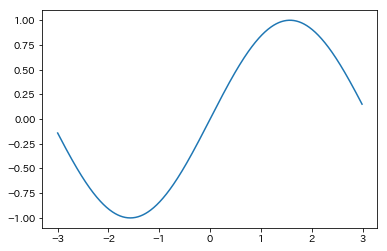

In [17]:
import matplotlib.pyplot as plt
x= np.arange(-3.0, 3.0, 0.01)
y = np.sin(x)
plt.plot(x,y)
plt.show()